# Regressão logística com PyTorch

Aluno: Marcel Pontes

Dataset link: https://www.kaggle.com/datasets/mrsimple07/student-exam-performance-prediction/data

# Importando o dataset diretamente do Kaggle

In [117]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mrsimple07/student-exam-performance-prediction")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'student-exam-performance-prediction' dataset.
Path to dataset files: /kaggle/input/student-exam-performance-prediction


In [118]:
import csv
import torch
import numpy as np

dataset_numpy = np.loadtxt(f"{path}/student_exam_data.csv", delimiter=",", skiprows=1)
col_names = next(csv.reader(open(f"{path}/student_exam_data.csv"), delimiter=","))
#dataset_pytorch = torch.from_numpy(dataset_numpy)

In [119]:
col_names

['Study Hours', 'Previous Exam Score', 'Pass/Fail']

# Normalização dos dados

In [120]:
X = dataset_numpy[:,0:2]
Y = dataset_numpy[:, -1].astype(int)

X -= X.min(axis=0)
X /= X.max(axis=0)

# Visualização da distribuição dos dados

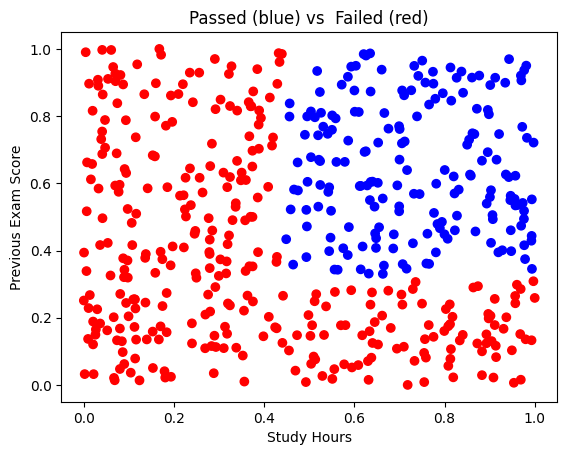

In [121]:
import matplotlib.pyplot as plt

colors = np.array(['r','b'])
plt.scatter(X[:, 0], X[:, 1], c=colors[Y])

plt.xlabel('Study Hours')
plt.ylabel('Previous Exam Score')
plt.title("Passed (blue) vs  Failed (red)")
plt.show()

# Separação dos conjuntos de treino e validação

In [122]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size = 0.2, random_state=42)

In [123]:
x_train_tensor = torch.FloatTensor(x_train)
y_train_tensor = torch.LongTensor(y_train)
x_val_tensor = torch.FloatTensor(x_val)
y_val_tensor = torch.LongTensor(y_val)

# Criação e treinamento do modelo

In [124]:
import torch.nn as nn

model = nn.Linear(2, 2)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [125]:
import torch.nn.functional as F

num_epochs = 10000

losses = []
losses_val = []
acc_list = []
acc_val_list = []

for epoch in range(num_epochs):
    outputs = model(x_train_tensor)
    outputs_val = model(x_val_tensor)

    loss = criterion(outputs, y_train_tensor)
    loss_val = criterion(outputs_val, y_val_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.data.item())
    losses_val.append(loss_val.data.item())

    _, class_max = torch.max(F.sigmoid(outputs), dim=1)
    _, class_max_val = torch.max(F.sigmoid(outputs_val), dim=1)
    acc_list.append((class_max == y_train_tensor).float().mean())
    acc_val_list.append((class_max_val == y_val_tensor).float().mean())

    if (epoch + 1) % 1000 == 0:
        print(f"Epoch: {epoch+1}/{num_epochs} Loss: {loss.item():.4f}")

Epoch: 1000/10000 Loss: 0.3216
Epoch: 2000/10000 Loss: 0.2859
Epoch: 3000/10000 Loss: 0.2728
Epoch: 4000/10000 Loss: 0.2663
Epoch: 5000/10000 Loss: 0.2626
Epoch: 6000/10000 Loss: 0.2603
Epoch: 7000/10000 Loss: 0.2589
Epoch: 8000/10000 Loss: 0.2579
Epoch: 9000/10000 Loss: 0.2572
Epoch: 10000/10000 Loss: 0.2567


# Avaliação

In [126]:
def predict(model, inputs):
  probabilities = model.forward(inputs)
  _, predicts = torch.max(probabilities, 1)
  return predicts.data.numpy()

In [127]:
Y_pred = predict(model, torch.FloatTensor(X))
accuracy = (Y_pred == Y).mean()
print("Acurácia da classificação:", accuracy)

Acurácia da classificação: 0.868


In [128]:
import pandas as pd
pd.crosstab(Y_pred, Y)

col_0,0,1
row_0,,
0,287,37
1,29,147


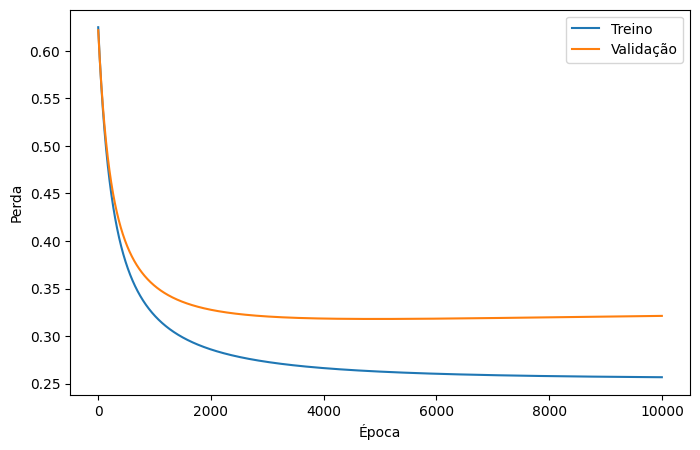

In [129]:
plt.figure(figsize=(8,5))
plt.plot(list(range(num_epochs)), losses, label="Treino")
plt.plot(list(range(num_epochs)), losses_val, label="Validação")

plt.xlabel("Época")
plt.ylabel("Perda")
plt.legend()
plt.show()

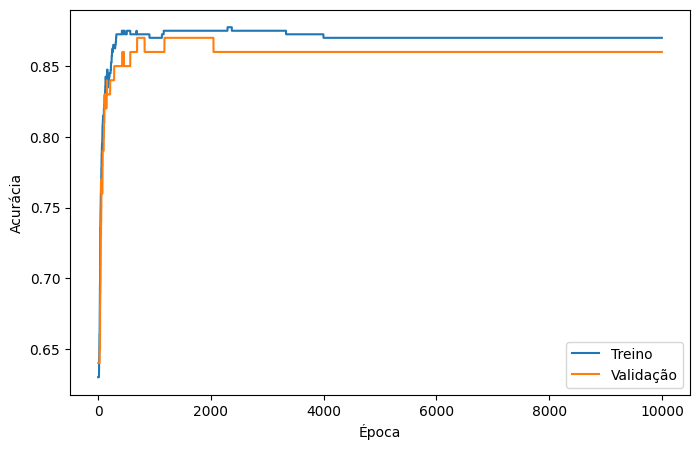

In [130]:
plt.figure(figsize=(8,5))
plt.plot(list(range(num_epochs)), acc_list, label="Treino")
plt.plot(list(range(num_epochs)), acc_val_list, label="Validação")

plt.xlabel("Época")
plt.ylabel("Acurácia")
plt.legend()
plt.show()

# Conclusões



*   O gráfico da variação da perda indica que o modelo apresenta overfit do conjunto de dados. Uma estratégia de regularização viria a ser interessante, mas não faz parte do escopo desta atividade
*   Observa-se que, para ter uma boa nota no próximo exame é esperado que o aluno possua uma boa nota no exame anterior, ou seja, tenha um histórico de boas notas, o que sugere um padrão de bom desempenho e hábitos de estudo, assim como o aluno deve ter estudado longas horas para o exame. Sem a combinação dos dois fatores, a visualização demonstra ser improvável um bom resultado na prova.
* Algumas valores de _learning rate_ foram experimentados e observou se que valores muito baixos realmente tendem a levar muito lentamente a uma convergência do algoritmo, com risco de deixar o treinamento preso em um mínimo local.

